# Proyecto Procesamiento de Señales e Imágenes


## Reconocimiento de covid a partir de registros de tos

#### Cristóbal Álvarez - 202073090-3

#### Importación de librerías

In [1]:
#!pip install matplotlib
#%pip install librosa
#!pip install ffmpeg
#%pip install moviepy
#!pip install torchaudio
#!pip install pydub
#!pip install IPython
#!pip install pyaudio

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

import moviepy.editor as mp

import torchaudio
import IPython
from IPython.display import Audio
from pydub import AudioSegment

import ffmpeg
import librosa
import librosa.display as librosa_display

import pyaudio
import random

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, precision_recall_curve,confusion_matrix,precision_score, recall_score,average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression

#### Funciones útiles

In [4]:
def grafico_barras_df(nombre_df):
    features = list(nombre_df.columns)
    histogram = [] # number of not NaN values

    for feature in features:
        histogram.append(nombre_df[feature].count())

    plt.bar(features, histogram)
    plt.xticks(range(len(features)), features, rotation='vertical', fontsize=6)
    plt.xlabel("Class")
    plt.ylabel("Number of samples")
    plt.show()

#### Obtención y tratamiento de datos

Number of samples: 27550
Number of classes / features: 51


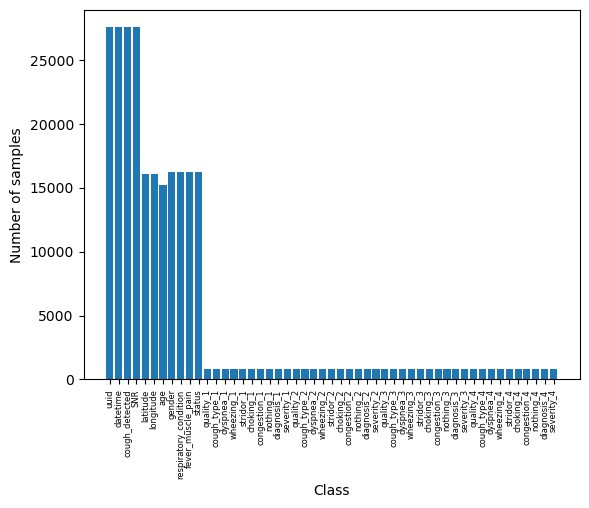

In [5]:
path_file = 'data/metadata_compiled.csv'
audio_files = pd.read_csv(path_file)

print("Number of samples: %d" % (len(audio_files)))
print("Number of classes / features: %d" % (len(audio_files.columns)))

grafico_barras_df(audio_files)

In [6]:
audio_files.dropna(subset=['status'], inplace=True)

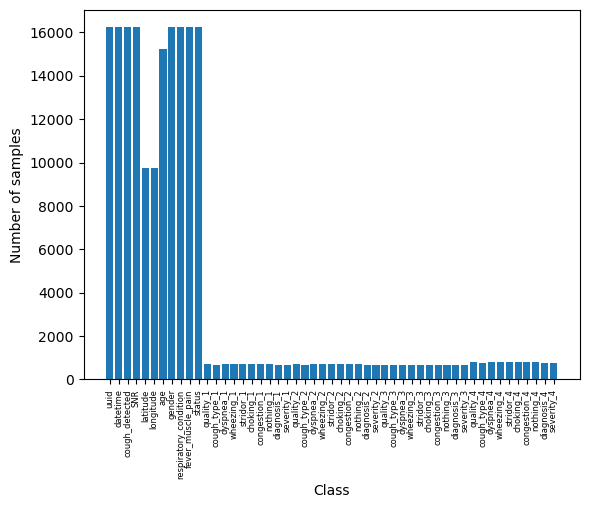

In [7]:
grafico_barras_df(audio_files)

In [8]:
audio_files = audio_files.query("cough_detected >= 0.7")

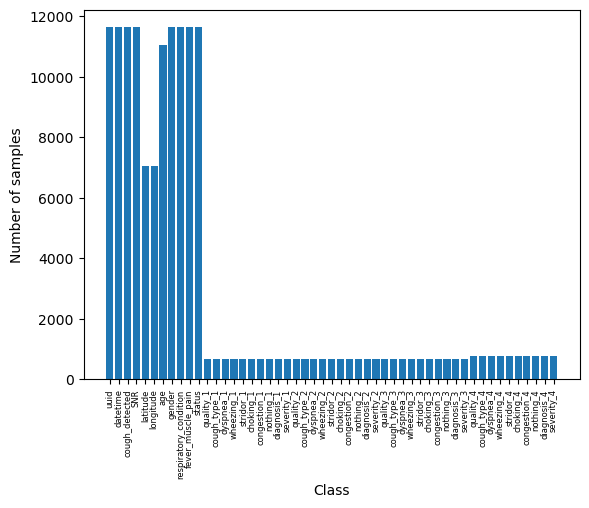

In [9]:
grafico_barras_df(audio_files)

In [10]:
datos_de_status = audio_files['status'].unique()
print(datos_de_status)

audio_files['Diagnostico'] = ''
audio_files.loc[audio_files['status'].isin(['healthy', 'symptomatic']), 'Diagnostico'] = 'No covid'
audio_files.loc[audio_files['status'] == 'COVID-19', 'Diagnostico'] = "COVID-19"

['healthy' 'symptomatic' 'COVID-19']


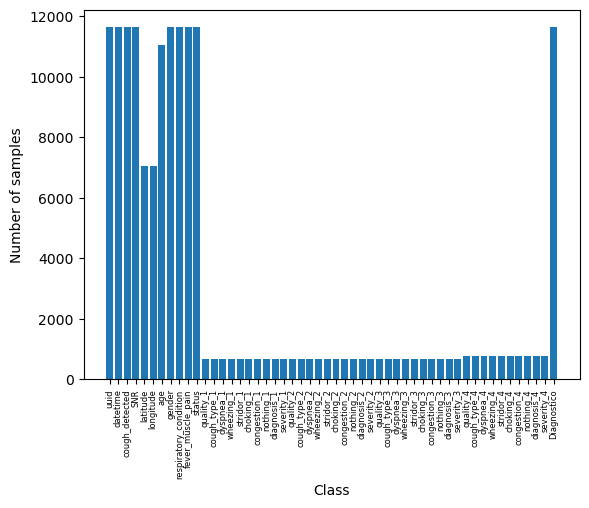

In [11]:
grafico_barras_df(audio_files)

In [12]:
datos_de_status = audio_files['Diagnostico'].unique()
print(datos_de_status)

['No covid' 'COVID-19']


### Eliminación de atributos no relevantes

Luego resulta necesario la eliminación de atributos que no son importantes para la predicción, dentro de estos encontramos datos como la fecha en que se toma el registro, datos geográficos como la latitud y la longitud y el status puesto que es reemplazado por el campo "diagnóstico"

In [13]:
audio_files = audio_files.drop(["status", "datetime", "latitude", "longitude", "age", "cough_detected"], axis = 1)

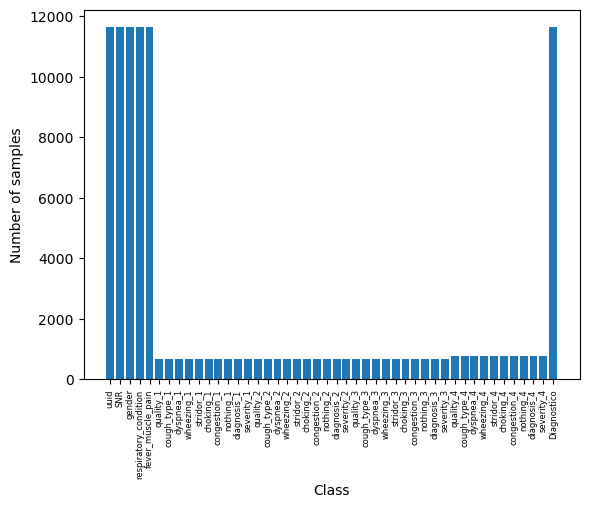

In [14]:
grafico_barras_df(audio_files)

## Procesamiento de audio

Ahora se debe pasar de los archivos de audio a un arreglo que contenga la información de la señal

Luego lo que hay que hacer es extraer información de la señal de audio y transformarla a un dataset.

In [15]:
def crear_df_features(features, uuid):
    
    datos = {}
    
    datos["uuid"] = [uuid]
    
    for i, elemento in enumerate(features):
        datos[f"columna_{i + 1}"] = [elemento]
    
    df = pd.DataFrame(datos)
    
    return df

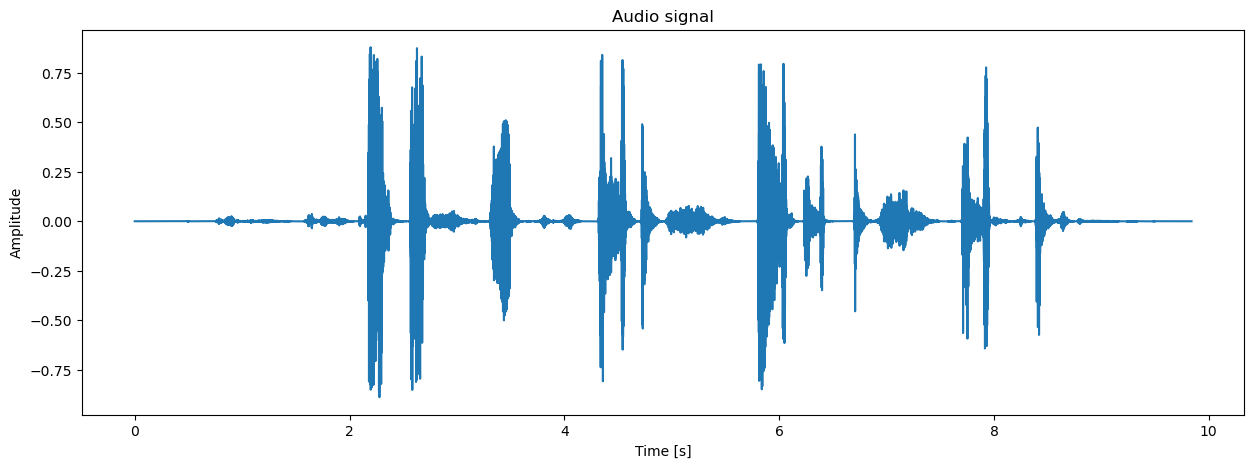

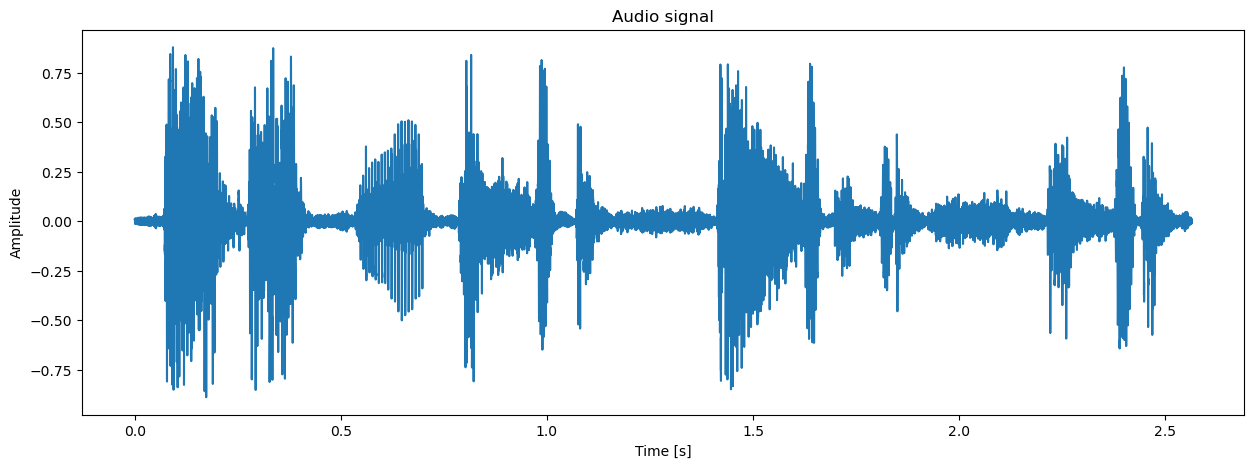

,uuid,columna_1,columna_2,columna_3,columna_4,columna_5,columna_6,columna_7,columna_8,columna_9,...,columna_21,columna_22,columna_23,columna_24,columna_25,columna_26,columna_27,columna_28,columna_29,columna_30
0,00ac8cb0-3384-46b2-9db5-5b5e911615f0,-186.29866,141.339233,-27.157316,-4.678879,-10.922605,-7.475416,0.062526,-10.157533,-13.331525,...,-4.931657,-3.573762,-3.647201,-4.211814,-3.532183,-2.455273,-2.132549,-2.171108,-1.885002,-1.379473


In [16]:
def convert_webm_to_wav(file_path):
    
    uuid = file_path
    
    file_path = "data/" + file_path + ".webm" 
    
    
    
    if not os.path.exists(file_path):
        #print("File not found")
        file_path = "data/" + uuid + ".ogg"
    '''
    else:
        #print("File found")
        continue
    '''

    t, sr = librosa.load(file_path, sr=None, mono=True, offset=0.0, duration=None, res_type='kaiser_fast')

    #print(t, sr)

    duration = t.shape[0] / sr

    time = np.linspace(0., duration, t.shape[0])
    
    
    plt.figure(figsize=(15, 5))
    plt.plot(time, t)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Audio signal")
    plt.show()
    
    
    t = np.delete(t, np.where(abs(t) < 0.01))
    
    duration = t.shape[0] / sr

    time = np.linspace(0., duration, t.shape[0])
    
    
    plt.figure(figsize=(15, 5))
    plt.plot(time, t)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Audio signal")
    plt.show()
    

    #IPython.display.display(IPython.display.Audio(t, rate=48000))
    
    mfccs_feature = librosa.feature.mfcc(y=t, sr=sr, n_mfcc=30)
    mfcc_scaled_feature=np.mean(mfccs_feature.T, axis=0)
    
    t_features = mfcc_scaled_feature
    
    #print(t_features)
    
    df = crear_df_features(t_features, uuid)
    
    #print(df.head(10))
    
    return df

convert_webm_to_wav("00ac8cb0-3384-46b2-9db5-5b5e911615f0")

In [17]:
'''
df = pd.DataFrame()

for uuid in audio_files["uuid"]:
    
    df2 = convert_webm_to_wav(uuid)
    
    df = df._append(df2, ignore_index = True)

'''
    

'\ndf = pd.DataFrame()\n\nfor uuid in audio_files["uuid"]:\n    \n    df2 = convert_webm_to_wav(uuid)\n    \n    df = df._append(df2, ignore_index = True)\n\n'

In [18]:
#df.to_csv('audio_features.csv')

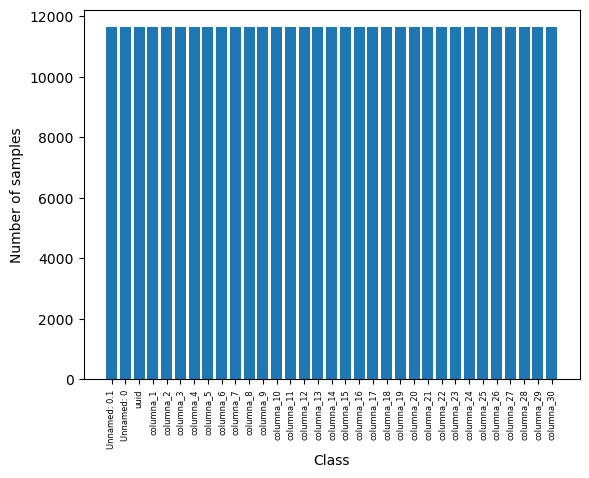

In [19]:
df = pd.read_csv('audio_features.csv')

grafico_barras_df(df)

## Definicion de datasets para cada modelo

Lo primero será separar el dataset de testing, el cual será común para cada uno de los modelos, debe corresponder a un dataset que contenga todos los datos necesarios para que el modelo que más atributos considera pueda funcionar, esto es, data de audio y data de evaluación médica.

In [20]:
audio_files_medical = audio_files

audio_files_medical = audio_files_medical.dropna(subset=['quality_1', 'quality_2', 'quality_3', 'quality_4'], how='all')

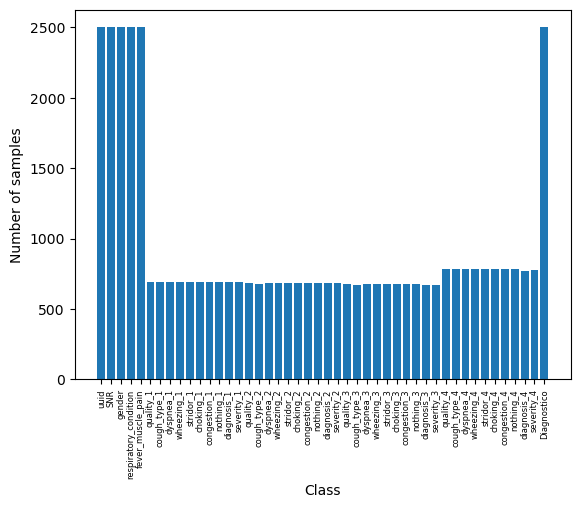

In [21]:
grafico_barras_df(audio_files_medical)

In [22]:
datos_de_status = audio_files['quality_1'].unique()
print(datos_de_status)

[nan 'ok' 'poor' 'good']


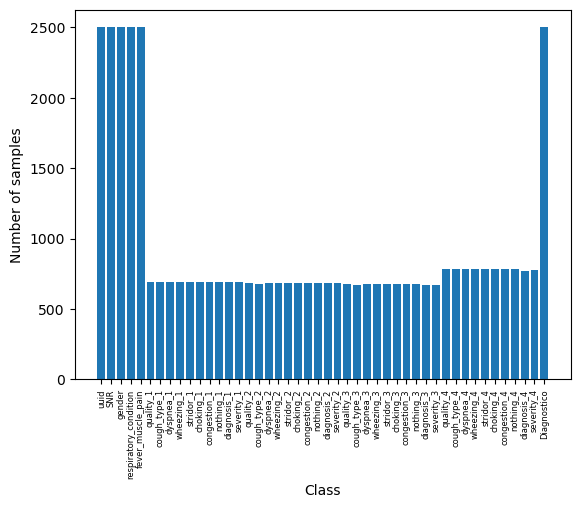

In [23]:
grafico_barras_df(audio_files_medical)

In [24]:
datos_de_status = audio_files['stridor_1'].unique()
print(datos_de_status)

[nan False]


In [25]:
df_pre_testing = audio_files_medical.merge(df, on='uuid', how='inner')

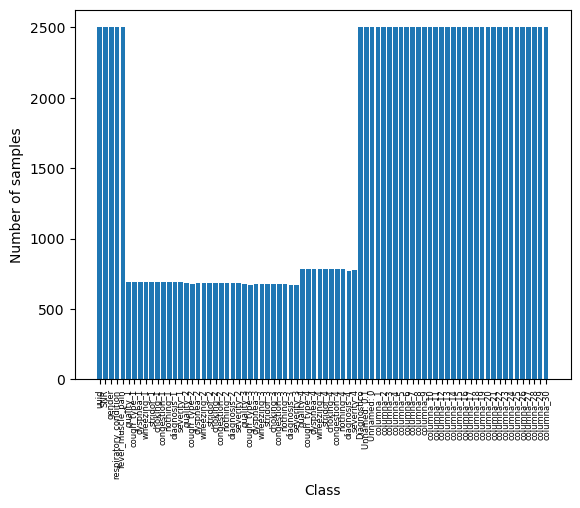

In [26]:
grafico_barras_df(df_pre_testing)

De estos datos se extraerán 600 que contendrán el dataset de testing

In [27]:
print(df_pre_testing.shape[0])

2500


In [28]:
random_seed = 42
random.seed(random_seed)

#Mezclar el dataset
df_pre_testing = df_pre_testing.sample(frac=1)

df_testing = df_pre_testing.head(600)

df_no_testing = df_pre_testing.head(1900)

In [29]:
df_testing_x = df_testing.drop("Diagnostico", axis = 1)
df_testing_y = df_testing["Diagnostico"]

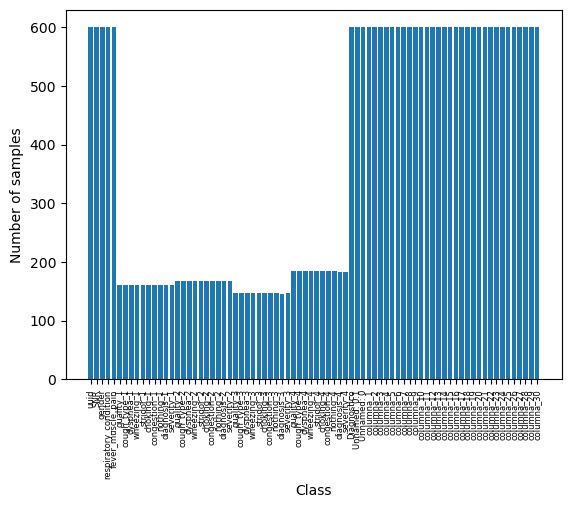

In [30]:
grafico_barras_df(df_testing)

### Unión del dataset original y dataset de información registros sonoro

Una vez obtenido el dataset de testing, este no se tocará más hasta comparar los modelos, sin embargo, aún falta armar el dataset que servirá de base para los demás datasets que ocupan los distintos modelos. Para esto se deben eliminar del dataset "audio_files" todos los registros que corresponden al dataset de testing y también se debe hacer la unión entre este dataset y el obtenido de los registros sonoros

In [31]:
print(audio_files.shape[0])

11634


In [32]:
#Eliminar los elementos presentes en dataframe de testing
audio_files_filtrado = audio_files[~audio_files["uuid"].isin(df_testing["uuid"])]

#Unir este dataframe con el de características de los audios
audio_files = audio_files_filtrado.merge(df, on='uuid', how='inner')

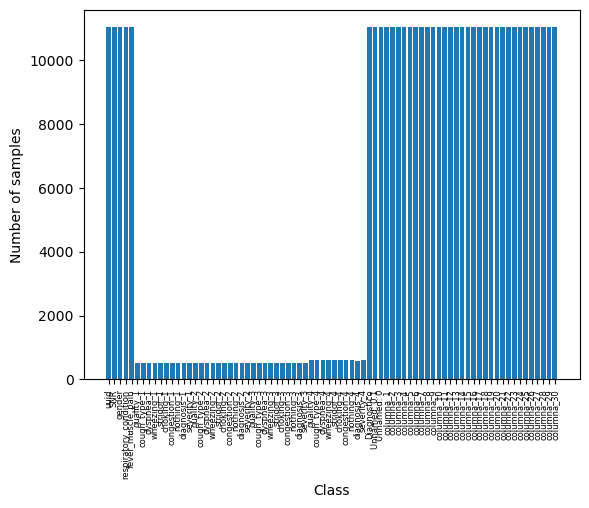

In [33]:
grafico_barras_df(audio_files)

In [34]:
print(audio_files.shape[0])

11034


#### Resultan 11034 datos con los que se podrán armar los demás datasets.

## Dataframe para modelo predictor con información de audio exclusivamente

Todos los datos que quedan cuentan con información de los audios por lo que este dataset puede ser bastante grande sin problemas, basta con eliminar las columnas asociadas a los comentarios médicos.

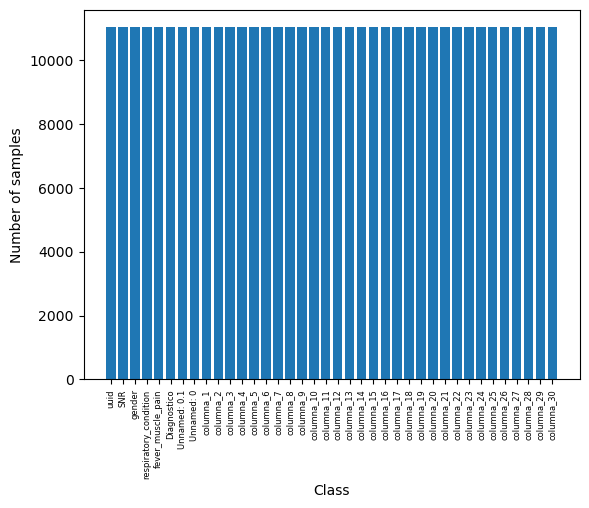

In [35]:
df_audio = audio_files

columnas = ['quality_1', 'cough_type_1', 'dyspnea_1', 'wheezing_1', 'stridor_1', 'choking_1', 'congestion_1', 'nothing_1', 'diagnosis_1', 'severity_1',
            'quality_2', 'cough_type_2', 'dyspnea_2', 'wheezing_2', 'stridor_2', 'choking_2', 'congestion_2', 'nothing_2', 'diagnosis_2', 'severity_2',
            'quality_3', 'cough_type_3', 'dyspnea_3', 'wheezing_3', 'stridor_3', 'choking_3', 'congestion_3', 'nothing_3', 'diagnosis_3', 'severity_3',
            'quality_4', 'cough_type_4', 'dyspnea_4', 'wheezing_4', 'stridor_4', 'choking_4', 'congestion_4', 'nothing_4', 'diagnosis_4', 'severity_4']

df_audio = df_audio.drop(columns=columnas)

grafico_barras_df(df_audio)

## Dataframe para modelo predictor con información médica exclusivamente

Para este dataframe se deben extraer aquellos datos que cuenten con comentarios médicos de alguno de los especialistas y las columnas asociadas a datos del registro sonoro.

In [36]:
df_medical = audio_files

df_medical = df_medical.dropna(subset=['quality_1', 'quality_2', 'quality_3', 'quality_4'], how='all')

columnas2 = ["columna_1", "columna_2", "columna_3", "columna_4", "columna_5", "columna_6", "columna_7", "columna_8",
             "columna_9", "columna_10", "columna_11", "columna_12", "columna_13", "columna_14", "columna_15", 
             "columna_16", "columna_17", "columna_18", "columna_19", "columna_20", "columna_21", "columna_22", "columna_23", 
             "columna_24", "columna_25", "columna_26", "columna_27", "columna_28", "columna_29", "columna_30", "Unnamed: 0.1", "Unnamed: 0"]

df_medical = df_medical.drop(columns=columnas2)

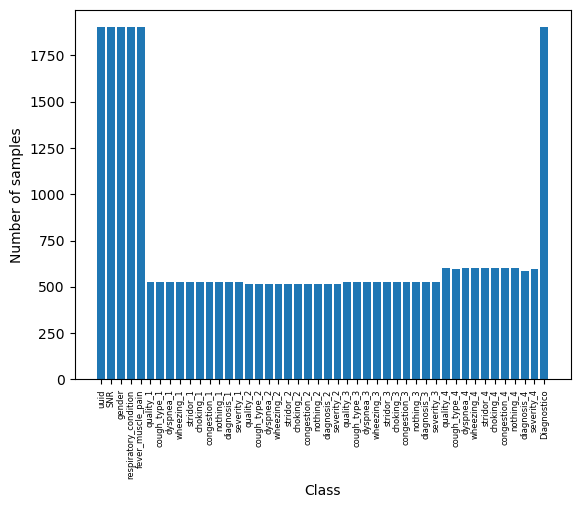

In [37]:
grafico_barras_df(df_medical)


## Dataframe para modelo predictor con información médica y de audio

Se eliminan todos los registros que no tienen evaluaciones médicas

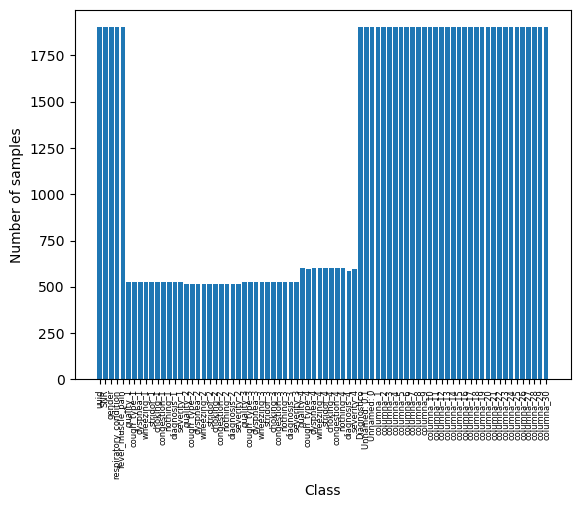

In [38]:
df_mixed = audio_files

df_mixed = df_mixed.dropna(subset=['quality_1', 'quality_2', 'quality_3', 'quality_4'], how='all')

features = list(df_mixed.columns)
histogram = [] # number of not NaN values

for feature in features:
    histogram.append(df_mixed[feature].count())

plt.bar(features, histogram)
plt.xticks(range(len(features)), features, rotation='vertical', fontsize=6)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.show()